In [1]:
import time
import tsaug
import numpy as np
from constants import *
from build_model import model_tools
from tsaug.visualization import plot
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


X = np.load('normalized/Norm_MinMax_%02d_X.npy' % window_size)
y = np.load('normalized/Norm_MinMax_%02d_y.npy' % window_size)

labels = np.unique(y)

In [2]:
X.shape

(1600, 10, 16)

In [8]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise, Convolve, Resize, Dropout, Pool

augmenters = {
    'AddNoise': AddNoise(scale=0.01),
    'Convolve': Convolve(window="flattop", size=10),
    'Crop': Crop(size=128),
    'Drift': Drift(max_drift=0.7, n_drift_points=5),
    'Dropout': Dropout(p=0.1, size=(1,5), fill=float("nan"), per_channel=True),
    'Pool': Pool(size=4),
    'Quantize': Quantize(n_levels=16),
    'Resize': Resize(size=16),
    'Reverse': Reverse(),
    'TimeWarp': TimeWarp(n_speed_change=5, max_speed_ratio=3)
}

# my_augmenter = (
#     AddNoise(scale=0.01)
#     + Convolve(window="flattop", size=10)
#     + Resize(size=16)
#     + TimeWarp(n_speed_change=5, max_speed_ratio=3)
# )

print("[INFO] Augmenting...")

def augmentation(X, y, X_out, y_out, method):
    X_aug = []
    print('[INFO] ' + method + '...')
    for x in X:
        X_aug.append(augmenters[method].augment(x))
    print('[DONE] ' + method + '.')
    return np.vstack((X_out, X_aug)), np.append(y_out, y)
    
X_augmented, y_augmented = X, y
X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'AddNoise')
X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'Convolve')
# X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'TimeWarp')
# X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'Drift')
# X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'Resize')
# X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'Quantize')
# X_augmented, y_augmented = augmentation(X, y, X_augmented, y_augmented, 'Pool')

print(X_augmented.shape)
print(y_augmented.shape)

[INFO] Augmenting...
[INFO] AddNoise...
[DONE] AddNoise.
[INFO] Convolve...
[DONE] Convolve.
(4800, 10, 16)
(4800,)


In [9]:
le = LabelEncoder()
le.fit(y_augmented)
le_y = np.array(le.transform(y_augmented))
le_y = le_y.reshape((-1, 1))

ohe = OneHotEncoder()
ohe.fit(le_y)

y_augmented = ohe.transform(le_y).toarray()
y_augmented.shape

(4800, 3)

In [10]:
model = model_tools(X_augmented, y_augmented, test_size=0.4, model_name='lstm_keras', n_layers=1, dropout=0.5)

Model: "lstm_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_0 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 2,163
Trainable params: 2,163
Non-trainable params: 0
_________________________________________________________________


uc: 0.9248 - val_loss: 0.4172 - val_accuracy: 0.8109 - val_auc: 0.9501 - lr: 0.0010
Epoch 7/100
2880/2880 [==============================] - 18s 6ms/step - loss: 0.4905 - accuracy: 0.7656 - auc: 0.9242 - val_loss: 0.4352 - val_accuracy: 0.7937 - val_auc: 0.9404 - lr: 0.0010
Epoch 8/100
2880/2880 [==============================] - 17s 6ms/step - loss: 0.4694 - accuracy: 0.7826 - auc: 0.9319 - val_loss: 0.4033 - val_accuracy: 0.8094 - val_auc: 0.9496 - lr: 0.0010
Epoch 9/100
2880/2880 [==============================] - 16s 6ms/step - loss: 0.4648 - accuracy: 0.7767 - auc: 0.9331 - val_loss: 0.4354 - val_accuracy: 0.7802 - val_auc: 0.9434 - lr: 0.0010
Epoch 10/100
2880/2880 [==============================] - 14s 5ms/step - loss: 0.4574 - accuracy: 0.7774 - auc: 0.9348 - val_loss: 0.5151 - val_accuracy: 0.7161 - val_auc: 0.9212 - lr: 0.0010
Epoch 11/100
2880/2880 [==============================] - 17s 6ms/step - loss: 0.4514 - accuracy: 0.7910 - auc: 0.9374 - val_loss: 0.3922 - val_accurac

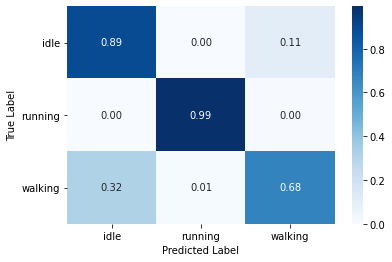

In [11]:
if not os.path.isdir(result_dir):  # For training
    os.mkdir(result_dir)
model.fit_and_save_model(es=False, mc=False, rlr=True, log=True)

In [12]:
# model.plt_fig()